## Installation

In [1]:
# # install package dependencies Seurat, scLink and dplyr
# install.packages('scLink',version='1.0.1')
# install.packages('dplyr')
# remotes::install_version("Seurat", "4.4.0")

In [2]:
# library(devtools)
# install_github("KChen-lab/transition-cells-identification",force=T)

In [3]:
library(CellTran)
options(warn=-1)

## Read data

In [4]:
# 读取 SERGIO 生成的模拟数据
library(Seurat)
n_tr <- 1000
n_st <- 500

# 1. 读取并创建 Seurat 对象（显式指定 assay 为 "RNA"）
data_transit <- read.csv('transit.csv', row.names = 1)
rownames(data_transit) <- paste0('gene_', 1:nrow(data_transit))
colnames(data_transit) <- paste0('cell_', 1:ncol(data_transit))
data_transit <- CreateSeuratObject(data_transit, assay = "RNA")  # 明确指定 assay
data_transit$bin <- c(rep(1, n_tr), rep(2, n_tr), rep(3, n_tr))

state <- read.csv('cell_state.csv', row.names = 1)
rownames(state) <- paste0('cell_', 1:ncol(data_transit))
colnames(state) <- 'state'
data_transit <- AddMetaData(data_transit, state)

data_stable <- read.csv("stable.csv", row.names = 1)
rownames(data_stable) <- paste0('gene_', 1:nrow(data_stable))
colnames(data_stable) <- paste0('cell_', (1 + ncol(data_transit)):(ncol(data_transit) + ncol(data_stable)))
data_stable <- CreateSeuratObject(data_stable, assay = "RNA")  # 明确指定 assay
data_stable$bin <- c(rep(1, n_st), rep(2, n_st), rep(3, n_st))
data_stable$state <- 'stable'

Attaching SeuratObject



Seurat v4 was just loaded with SeuratObject v5; disabling v5 assays and
validation routines, and ensuring assays work in strict v3/v4
compatibility mode



# Calculate transition index

In [5]:
# data pre-processing
data<-merge(data_transit,data_stable)
data<-NormalizeData(data)
data<- ScaleData(data)
data<- RunPCA(data, features = rownames(data))
data<- FindNeighbors(data, dims = 1: 5)
data<- FindClusters(data, resolution = 0.5)
data<- RunUMAP(data,dims=1:5)

Centering and scaling data matrix

Warning message in irlba(A = t(x = object), nv = npcs, ...):
"You're computing too large a percentage of total singular values, use a standard svd instead."
PC_ 1 
Positive:  gene-68, gene-83, gene-36, gene-73, gene-8, gene-10, gene-16, gene-50, gene-71, gene-62 
	   gene-29, gene-9, gene-55, gene-24, gene-46, gene-90, gene-95, gene-81, gene-87, gene-96 
	   gene-93, gene-1, gene-7, gene-37, gene-5, gene-4, gene-89, gene-78, gene-79, gene-85 
Negative:  gene-72, gene-63, gene-49, gene-67, gene-97, gene-92, gene-13, gene-41, gene-44, gene-15 
	   gene-11, gene-35, gene-98, gene-53, gene-38, gene-69, gene-59, gene-66, gene-52, gene-18 
	   gene-70, gene-17, gene-82, gene-100, gene-22, gene-30, gene-28, gene-60, gene-45, gene-76 
PC_ 2 
Positive:  gene-2, gene-42, gene-86, gene-56, gene-12, gene-39, gene-3, gene-6, gene-94, gene-80 
	   gene-74, gene-88, gene-45, gene-28, gene-60, gene-30, gene-76, gene-58, gene-14, gene-91 
	   gene-22, gene-100, gene-8

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 4500
Number of edges: 127916

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9029
Number of communities: 9
Elapsed time: 0 seconds


11:57:24 UMAP embedding parameters a = 0.9922 b = 1.112

11:57:24 Read 4500 rows and found 5 numeric columns

11:57:24 Using Annoy for neighbor search, n_neighbors = 30

11:57:24 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

11:57:24 Writing NN index file to temp file C:\Users\yingj\AppData\Local\Temp\RtmpCaOnMe\file6cf45e9453b0

11:57:24 Searching Annoy index using 1 thread, search_k = 3000

11:57:26 Annoy recall = 100%

11:57:26 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

11:57:27 Initializing from normalized Laplacian + noise (using irlba)

11:57:27 Commencing optimization for 500 epochs, with 163996 positive edges

11:57:27 Using rng type: pcg

11:57:35 Optimization finished



In [6]:
data

An object of class Seurat 
100 features across 4500 samples within 1 assay 
Active assay: RNA (100 features, 0 variable features)
 3 layers present: counts, data, scale.data
 2 dimensional reductions calculated: pca, umap

In [7]:
#' Calculate GPPCCs
#'
#' This is the function calculating gene pair-wise Pearson's correlation coefficients (GPPCCs). 
#' The GPPCCs calculated using our method are assumed from the cells that exhibit similar 
#' regulatory profiles and around equilibrium points. Thus, for each cell, we select the cell 
#' together with its nearest neighbors in Principal Component Analysis (PCA) dimensions based 
#' on cosine distance to calculate GPPCCs. We also use scLink in the calculation to deal with
#' the gene expression values affected by dropout. 
#' @param data Seurat object containing both count matrix and metadata such as neighboring 
#' results for a single-cell dataset.
#' @param highly_variable_gene A gene list containing top most variable genes. Calculated 
#' by \code{var} function by default.
#' @param n_neighbor The number of neighboring cells used to calculate GPPCCs. 300 by default.
#' @return A matrix of GPPCCs. Rows are cells and columns are gene pairs.
#' @import Seurat
#' @import scLink
#' @import dplyr
#' @export
gene_pearson<-function(data,highly_variable_gene=NULL,n_neighbor=300,n_gene=50,...){
        res<-NULL
        exprs<-as.matrix(GetAssayData(data))
        if(is.null(highly_variable_gene)){
                highly_variable_gene<-order(apply(as.matrix(exprs),1,function(x) var(x)),decreasing=T)[1:n_gene]
                highly_variable_gene<-rownames(exprs)[highly_variable_gene]
        }
        for(c in data %>% colnames()){
                expr<-t(exprs[highly_variable_gene,data@neighbors$RNA.nn@nn.idx[match(c,data@neighbors$RNA.nn@cell.names),]])
                pearson_cor<-scLink::sclink_cor(expr = expr, ncores = 1)
                diag(pearson_cor)<-NA
                res<-rbind(res,as.numeric(pearson_cor))
        }
        rownames(res)<-colnames(data)
        gene_name<-highly_variable_gene
        name_tmp<-character()
        for(i in gene_name){
                for(j in gene_name)
                        name_tmp<-c(name_tmp,paste(i,j,sep='_'))
         }
        colnames(res)<-name_tmp
        return(res)
}


find_ks_d<-function(x,y){
        n.x <- length(x)
        n.y <- length(y)
        w <- c(x, y)
        z <- cumsum(ifelse(order(w) <= n.x, 1/n.x, -1/n.y))
        w_sort<-sort(w)
        w_max<-max(w_sort[z==max(z)])
        z_sub<-z[w_sort>w_max]
        w_min<-min(w_sort[w_sort>w_max][z_sub==min(z_sub)])
        return(list('w_min'=w_min,'w_max'=w_max))
}

#' Calculate transition index
#'
#' This is the function calculating transition index that reflects the transition
#' probability of a cell. The transition index we defined is inspired by Kolmogorov-Smirnov 
#' statistic. We assume there are both transition cells and stable cells captured by  
#' scRNA-seq in the data. We first find the archetype of transition 
#' cell and stable cell by using modified Kolmogorov-Smirnov statistic. As proved 
#' mathematically, there are more gene pairs whose absolute value of Pearson鈥檚 
#' correlation coefficients are close to 1 in transition cells than stable cells. 
#' Thus, based on the distribution difference, by finding the maximum difference 
#' among all cells, we identify archetypal stable cells and transition cells. To 
#' count and compare the number of gene pairs exceeding such threshold in each cell, 
#' we define transition index by summarizing the percentage of gene pairs whose 
#' absolute value of Pearson鈥檚 correlation coefficients are between argmax_x(D_max)    
#' and argmin_x(D_max). 
#'
#' @param data Seurat object containing both count matrix and metadata such as neighboring 
#' results for a single-cell dataset.
#' @param highly_variable_gene A gene list containing top most variable genes. Calculated 
#' by \code{var} function by default.
#' @param group The cell group highly_variable_genes selected based on. It should be a column
#' name of data@meta.data, such as 'seurat_clusters','cell_type','time_point'. Using 
#' 'seurat_clusters' by default. 
#' @param n_neighbor The number of neighboring cells used to calculate GPPCCs. 300 by default.
#' @param n_gene The number of top most variable genes used in calculating GPPCCs. 50 by default.
#' @param return_pearson Whether report GPPCCs or not. Using False by default.
#' @return If return_pearson is False, return a Seurat object. Calculated transition index is 
#' store as a column in the metadata. If return_pearson is True, return a list. Calculated 
#' transition index is stored in the data element, as a column in the metadata. GPPCCs is stored
#' in the GPPCCs element.
#' @import Seurat
#' @import scLink
#' @import dplyr
#' @export
transition_index<-function(data,highly_variable_gene=NULL,group='seurat_clusters',n_neighbors=300,n_gene=50,return_pearson=FALSE,...){
    res<-list()
    for(i in data@meta.data[,group] %>% unique()){
            print(i)
            data_sub<-data[,data@meta.data[,group]==i]
            if(ncol(data_sub)<=n_neighbors)
                    next
            data_sub<-Seurat::FindVariableFeatures(data_sub, selection.method = "vst", nfeatures = 2000)
            data_sub<- Seurat::ScaleData(data_sub,vars.to.regress="nCount_RNA")
            data_sub<- Seurat::RunPCA(data_sub, features = VariableFeatures(object = data_sub),npcs=min(20,ncol(data_sub)))
            data_sub<- Seurat::FindNeighbors(data_sub, dims = 1: min(20,ncol(data_sub)),return.neighbor = TRUE,k.param=n_neighbors,annoy.metric='cosine')
            pearson<-gene_pearson(data_sub,highly_variable_gene=highly_variable_gene,n_neighbor=n_neighbors,n_gene=n_gene)
            # fine tuning  (optional)
            pearson<-abs(pearson)
            res_1<-apply(pearson,1,function(x) ks.test(x,pearson[1,],alternative='greater')$statistic)
            res_2<-apply(pearson,1,function(x) ks.test(x,pearson[1,],alternative='less')$statistic)
            res_tmp<-find_ks_d(pearson[which.max(res_1),],pearson[which.max(res_2),])
            tmp<-apply(pearson,1,function(x) sum(abs(x)>min(unlist(res_tmp)) & abs(x)<max(unlist(res_tmp)),na.rm=T)/sum(abs(x)>=0,na.rm=T))
            data_sub<-Seurat::AddMetaData(data_sub,data.frame('pearson'=tmp))
            if(min(tmp)==max(tmp)){
                    res[[as.character(i)]]<-pearson
                    next
            }
            cell<-data_sub@meta.data %>% dplyr::filter(pearson>quantile(data_sub$pearson,0.8,na.rm=T)) %>% rownames()
            hvg<-sort(apply(as.matrix(GetAssayData(data_sub[,cell])),1,function(x) var(x)),decreasing=T)[1:n_gene] %>% names
            pearson<-gene_pearson(data_sub,n_neighbor=n_neighbors,highly_variable_gene=hvg)
            res[[as.character(i)]]<-pearson
    }
    res<-Reduce(function(x,y) rbind(x,y),res)
    pearson<-res
    res<-abs(res)
    res_1<-apply(res,1,function(x) ks.test(x,res[1,],alternative='greater')$statistic)
    res_2<-apply(res,1,function(x) ks.test(x,res[1,],alternative='less')$statistic)
    res_tmp<-find_ks_d(res[which.max(res_1),],res[which.max(res_2),])
    tmp<-apply(res,1,function(x) sum(abs(x)>min(unlist(res_tmp)) & abs(x)<max(unlist(res_tmp)),na.rm=T)/sum(abs(x)>=0,na.rm=T))
    data<-Seurat::AddMetaData(data,data.frame('transition_index'=tmp))
    if(!return_pearson)
    return(data)
    else
    return(list('GPPCCs'=pearson,'data'=data))
}


In [8]:
# calculate transition index
library(dplyr)
data<-transition_index(data,n_neighbor=50,n_gene=100)


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union




[1] "3"


Regressing out nCount_RNA

Centering and scaling data matrix

PC_ 1 
Positive:  gene-75, gene-19, gene-1, gene-12, gene-25, gene-62, gene-79, gene-28, gene-86, gene-63 
	   gene-81, gene-10, gene-52, gene-68, gene-35, gene-4, gene-54, gene-11, gene-58, gene-90 
	   gene-95, gene-13, gene-85, gene-30, gene-8, gene-89, gene-92, gene-20, gene-18, gene-84 
Negative:  gene-38, gene-2, gene-80, gene-82, gene-14, gene-42, gene-36, gene-17, gene-49, gene-69 
	   gene-56, gene-76, gene-48, gene-67, gene-74, gene-53, gene-50, gene-24, gene-98, gene-41 
	   gene-29, gene-87, gene-64, gene-37, gene-99, gene-91, gene-72, gene-5, gene-60, gene-3 
PC_ 2 
Positive:  gene-70, gene-6, gene-72, gene-42, gene-100, gene-17, gene-9, gene-45, gene-88, gene-5 
	   gene-75, gene-48, gene-4, gene-79, gene-28, gene-12, gene-86, gene-52, gene-57, gene-65 
	   gene-43, gene-78, gene-91, gene-80, gene-41, gene-77, gene-58, gene-40, gene-76, gene-15 
Negative:  gene-84, gene-39, gene-27, gene-47, gene-66, gene-55, g

[1] "2"


Regressing out nCount_RNA

Centering and scaling data matrix

PC_ 1 
Positive:  gene-48, gene-89, gene-93, gene-53, gene-54, gene-82, gene-55, gene-77, gene-42, gene-37 
	   gene-10, gene-85, gene-38, gene-16, gene-64, gene-5, gene-33, gene-39, gene-12, gene-45 
	   gene-72, gene-73, gene-15, gene-26, gene-7, gene-51, gene-60, gene-97, gene-94, gene-61 
Negative:  gene-20, gene-41, gene-100, gene-35, gene-4, gene-90, gene-67, gene-66, gene-86, gene-21 
	   gene-74, gene-29, gene-56, gene-19, gene-88, gene-28, gene-49, gene-69, gene-6, gene-30 
	   gene-78, gene-14, gene-91, gene-52, gene-70, gene-34, gene-50, gene-44, gene-81, gene-79 
PC_ 2 
Positive:  gene-30, gene-16, gene-7, gene-45, gene-62, gene-3, gene-98, gene-17, gene-65, gene-36 
	   gene-27, gene-44, gene-2, gene-37, gene-88, gene-94, gene-28, gene-13, gene-10, gene-66 
	   gene-41, gene-52, gene-84, gene-18, gene-49, gene-92, gene-67, gene-6, gene-50, gene-77 
Negative:  gene-75, gene-20, gene-71, gene-47, gene-26, gene-31,

[1] "8"


Regressing out nCount_RNA

Centering and scaling data matrix

PC_ 1 
Positive:  gene-39, gene-50, gene-26, gene-31, gene-67, gene-99, gene-63, gene-46, gene-78, gene-89 
	   gene-24, gene-23, gene-73, gene-100, gene-72, gene-60, gene-94, gene-13, gene-96, gene-92 
	   gene-69, gene-40, gene-71, gene-34, gene-43, gene-28, gene-84, gene-16, gene-64, gene-9 
Negative:  gene-2, gene-79, gene-38, gene-42, gene-11, gene-15, gene-86, gene-85, gene-44, gene-56 
	   gene-95, gene-68, gene-41, gene-30, gene-27, gene-7, gene-36, gene-82, gene-90, gene-17 
	   gene-76, gene-18, gene-88, gene-77, gene-74, gene-97, gene-32, gene-93, gene-1, gene-87 
PC_ 2 
Positive:  gene-35, gene-80, gene-59, gene-4, gene-18, gene-88, gene-92, gene-5, gene-98, gene-40 
	   gene-32, gene-57, gene-45, gene-34, gene-8, gene-16, gene-47, gene-56, gene-78, gene-20 
	   gene-67, gene-46, gene-91, gene-38, gene-21, gene-36, gene-9, gene-76, gene-71, gene-42 
Negative:  gene-19, gene-62, gene-61, gene-75, gene-25, gene-74,

[1] "5"


Regressing out nCount_RNA

Centering and scaling data matrix

PC_ 1 
Positive:  gene-9, gene-54, gene-10, gene-1, gene-37, gene-55, gene-8, gene-5, gene-24, gene-89 
	   gene-62, gene-46, gene-71, gene-7, gene-29, gene-4, gene-16, gene-78, gene-50, gene-99 
	   gene-33, gene-84, gene-31, gene-43, gene-19, gene-26, gene-61, gene-47, gene-23, gene-32 
Negative:  gene-72, gene-13, gene-97, gene-41, gene-70, gene-92, gene-18, gene-66, gene-69, gene-38 
	   gene-35, gene-49, gene-15, gene-52, gene-44, gene-98, gene-63, gene-82, gene-11, gene-59 
	   gene-67, gene-53, gene-17, gene-22, gene-100, gene-2, gene-94, gene-56, gene-12, gene-86 
PC_ 2 
Positive:  gene-19, gene-34, gene-25, gene-61, gene-47, gene-68, gene-51, gene-83, gene-27, gene-23 
	   gene-33, gene-43, gene-21, gene-26, gene-99, gene-31, gene-75, gene-40, gene-32, gene-64 
	   gene-73, gene-48, gene-36, gene-65, gene-84, gene-20, gene-57, gene-80, gene-53, gene-15 
Negative:  gene-76, gene-45, gene-30, gene-60, gene-6, gene-28,

[1] "6"


Regressing out nCount_RNA

Centering and scaling data matrix

PC_ 1 
Positive:  gene-38, gene-92, gene-15, gene-72, gene-35, gene-11, gene-59, gene-66, gene-70, gene-44 
	   gene-69, gene-13, gene-52, gene-18, gene-41, gene-53, gene-49, gene-82, gene-67, gene-97 
	   gene-17, gene-98, gene-63, gene-100, gene-22, gene-80, gene-2, gene-56, gene-94, gene-39 
Negative:  gene-9, gene-37, gene-50, gene-5, gene-1, gene-8, gene-7, gene-54, gene-24, gene-10 
	   gene-71, gene-16, gene-55, gene-4, gene-87, gene-89, gene-29, gene-62, gene-79, gene-78 
	   gene-31, gene-77, gene-34, gene-43, gene-46, gene-90, gene-19, gene-84, gene-61, gene-32 
PC_ 2 
Positive:  gene-45, gene-30, gene-74, gene-28, gene-6, gene-58, gene-14, gene-76, gene-88, gene-60 
	   gene-7, gene-8, gene-9, gene-12, gene-5, gene-18, gene-79, gene-89, gene-80, gene-37 
	   gene-55, gene-67, gene-10, gene-24, gene-94, gene-49, gene-54, gene-100, gene-82, gene-17 
Negative:  gene-36, gene-83, gene-34, gene-27, gene-61, gene-68, ge

[1] "0"


Regressing out nCount_RNA

Centering and scaling data matrix

PC_ 1 
Positive:  gene-59, gene-11, gene-63, gene-17, gene-72, gene-67, gene-53, gene-15, gene-52, gene-69 
	   gene-97, gene-44, gene-66, gene-18, gene-38, gene-49, gene-13, gene-41, gene-92, gene-70 
	   gene-98, gene-35, gene-100, gene-82, gene-22, gene-83, gene-56, gene-94, gene-68, gene-36 
Negative:  gene-74, gene-30, gene-60, gene-88, gene-14, gene-76, gene-28, gene-45, gene-6, gene-20 
	   gene-33, gene-58, gene-51, gene-61, gene-9, gene-7, gene-54, gene-31, gene-1, gene-55 
	   gene-16, gene-25, gene-79, gene-24, gene-37, gene-99, gene-8, gene-29, gene-43, gene-5 
PC_ 2 
Positive:  gene-2, gene-86, gene-83, gene-10, gene-29, gene-55, gene-24, gene-50, gene-95, gene-63 
	   gene-91, gene-22, gene-62, gene-58, gene-68, gene-85, gene-56, gene-96, gene-100, gene-93 
	   gene-76, gene-71, gene-81, gene-44, gene-73, gene-37, gene-46, gene-36, gene-79, gene-45 
Negative:  gene-19, gene-51, gene-75, gene-61, gene-25, gene-3

[1] "7"


Regressing out nCount_RNA

Centering and scaling data matrix

PC_ 1 
Positive:  gene-34, gene-19, gene-43, gene-99, gene-47, gene-23, gene-27, gene-61, gene-51, gene-32 
	   gene-26, gene-33, gene-25, gene-31, gene-21, gene-75, gene-20, gene-84, gene-65, gene-77 
	   gene-40, gene-62, gene-64, gene-55, gene-29, gene-50, gene-57, gene-70, gene-85, gene-17 
Negative:  gene-10, gene-22, gene-4, gene-87, gene-100, gene-89, gene-82, gene-93, gene-7, gene-78 
	   gene-81, gene-80, gene-5, gene-91, gene-3, gene-96, gene-90, gene-73, gene-68, gene-95 
	   gene-12, gene-94, gene-37, gene-79, gene-86, gene-52, gene-54, gene-74, gene-8, gene-72 
PC_ 2 
Positive:  gene-10, gene-9, gene-76, gene-60, gene-74, gene-88, gene-24, gene-58, gene-6, gene-79 
	   gene-50, gene-30, gene-5, gene-45, gene-1, gene-7, gene-28, gene-8, gene-54, gene-29 
	   gene-62, gene-16, gene-14, gene-37, gene-55, gene-71, gene-3, gene-48, gene-84, gene-4 
Negative:  gene-72, gene-66, gene-44, gene-15, gene-83, gene-52, gene

[1] "4"


Regressing out nCount_RNA

Centering and scaling data matrix

PC_ 1 
Positive:  gene-83, gene-68, gene-73, gene-69, gene-72, gene-38, gene-18, gene-63, gene-52, gene-97 
	   gene-66, gene-35, gene-2, gene-98, gene-26, gene-41, gene-13, gene-36, gene-15, gene-44 
	   gene-100, gene-70, gene-67, gene-25, gene-49, gene-53, gene-11, gene-47, gene-43, gene-75 
Negative:  gene-7, gene-9, gene-1, gene-37, gene-8, gene-5, gene-10, gene-28, gene-60, gene-79 
	   gene-54, gene-6, gene-30, gene-76, gene-14, gene-88, gene-62, gene-29, gene-55, gene-16 
	   gene-89, gene-71, gene-74, gene-58, gene-45, gene-24, gene-78, gene-4, gene-50, gene-46 
PC_ 2 
Positive:  gene-86, gene-88, gene-6, gene-2, gene-60, gene-76, gene-30, gene-45, gene-58, gene-28 
	   gene-14, gene-74, gene-17, gene-94, gene-22, gene-92, gene-79, gene-82, gene-70, gene-49 
	   gene-100, gene-15, gene-81, gene-63, gene-12, gene-13, gene-98, gene-44, gene-97, gene-72 
Negative:  gene-4, gene-68, gene-36, gene-78, gene-89, gene-54, g

[1] "1"


Regressing out nCount_RNA

Centering and scaling data matrix

PC_ 1 
Positive:  gene-36, gene-82, gene-66, gene-5, gene-35, gene-86, gene-93, gene-84, gene-34, gene-40 
	   gene-14, gene-3, gene-62, gene-37, gene-78, gene-1, gene-95, gene-6, gene-45, gene-4 
	   gene-73, gene-43, gene-30, gene-97, gene-2, gene-69, gene-77, gene-24, gene-83, gene-68 
Negative:  gene-13, gene-67, gene-64, gene-98, gene-65, gene-32, gene-27, gene-25, gene-53, gene-7 
	   gene-70, gene-79, gene-81, gene-20, gene-60, gene-9, gene-90, gene-51, gene-50, gene-74 
	   gene-94, gene-75, gene-10, gene-46, gene-59, gene-76, gene-22, gene-91, gene-8, gene-80 
PC_ 2 
Positive:  gene-57, gene-83, gene-8, gene-50, gene-75, gene-72, gene-19, gene-71, gene-73, gene-80 
	   gene-37, gene-58, gene-88, gene-44, gene-65, gene-39, gene-64, gene-34, gene-1, gene-14 
	   gene-74, gene-93, gene-55, gene-66, gene-67, gene-95, gene-28, gene-27, gene-46, gene-11 
Negative:  gene-87, gene-9, gene-53, gene-47, gene-76, gene-3, gene-

##Visualization

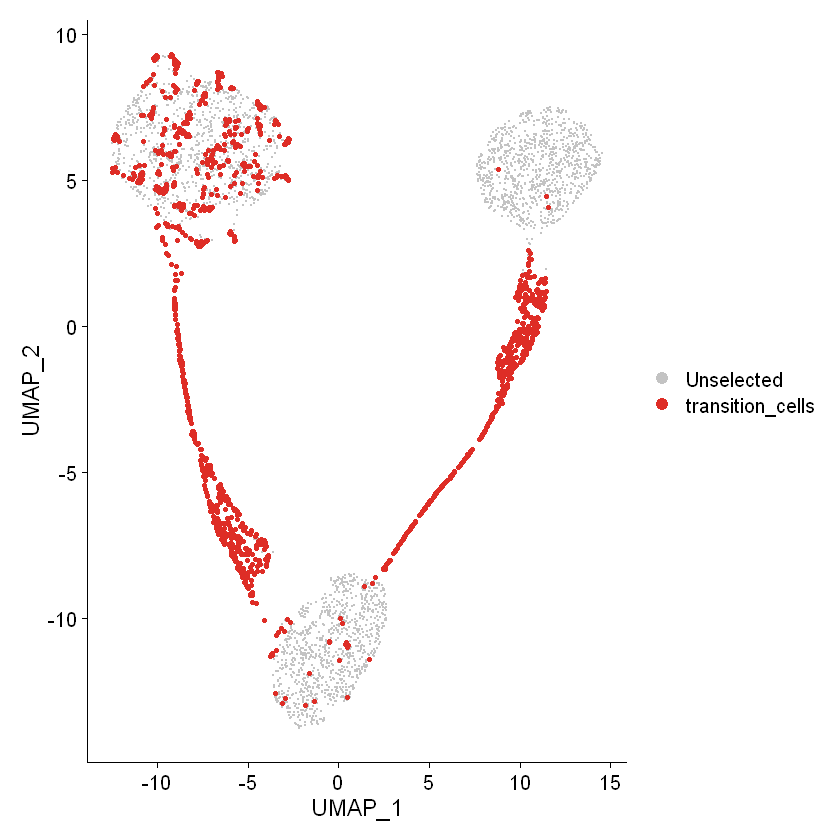

In [9]:
# 5. 可视化
# UMAP 按真实标签着色（过渡细胞标红）
DimPlot(data, cells.highlight = list('transition_cells' = colnames(subset(data, state == 'transit'))))

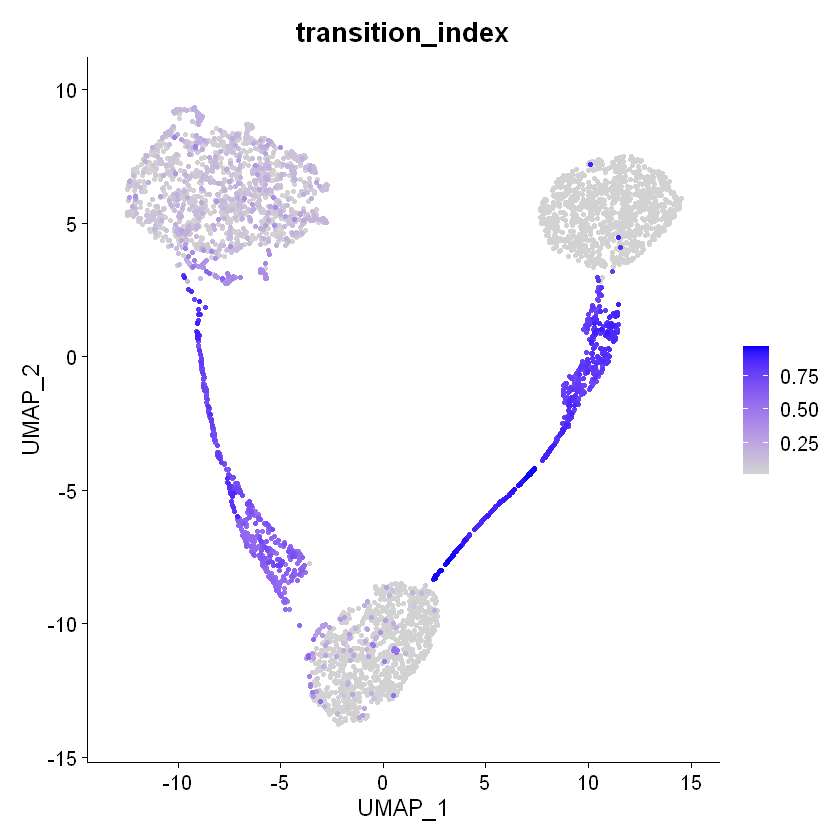

In [10]:
# UMAP 按 Transition Index 着色
FeaturePlot(data, features = 'transition_index', order = TRUE, pt.size = 1)

In [13]:
write.table(data$transition_index, 
            file = "celltran_data/transition_index.csv",
            row.names = FALSE,
            col.names = FALSE,
            sep = ",")

# Evaluation

package 'yardstick' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\yingj\AppData\Local\Temp\Rtmp8KXMua\downloaded_packages
package 'pROC' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\yingj\AppData\Local\Temp\Rtmp8KXMua\downloaded_packages


Registered S3 method overwritten by 'yardstick':
  method       from         
  print.metric spatstat.geom



[1] "PRAUC:0.9"


Type 'citation("pROC")' for a citation.


Attaching package: 'pROC'


The following objects are masked from 'package:stats':

    cov, smooth, var


Setting levels: control = transit, case = stable

Setting direction: controls > cases



[1] "AUROC:0.96"


null device 
          1

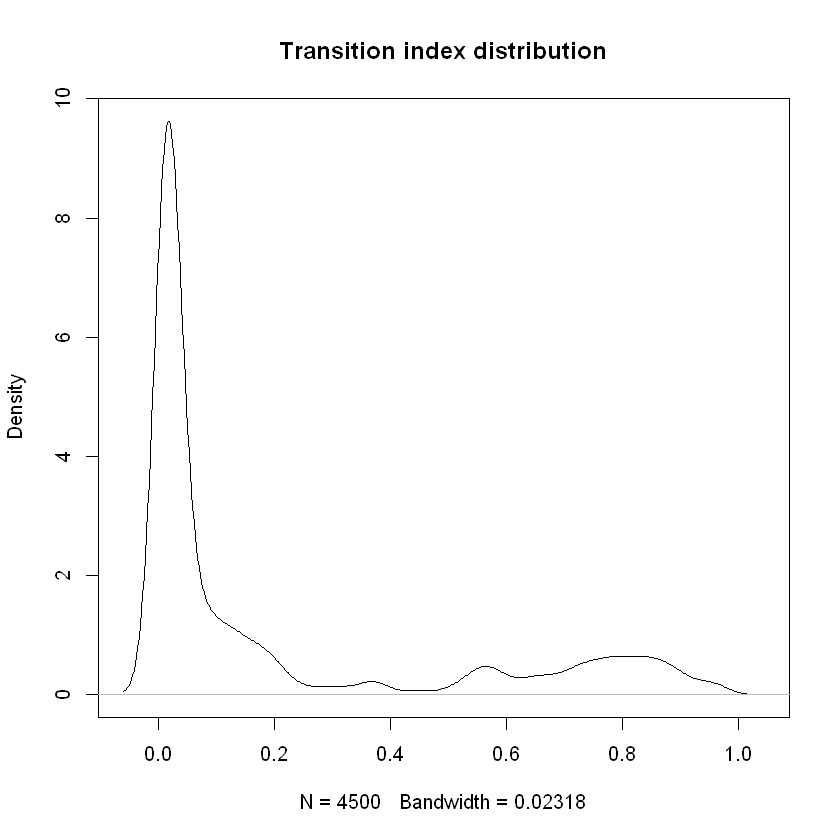

In [ ]:
# 6. 评估指标（AUROC, PRAUC）
install.packages('yardstick')
install.packages('pROC')
library(yardstick)
data$state <- factor(data$state, levels = c('transit', 'stable'))
print(paste0('PRAUC:', round(pr_auc_vec(data$state, data$transition_index), 2)))
library(pROC)
print(paste0('AUROC:', round(roc(data$state, data$transition_index)$auc, 2)))

plot(density(data$transition_index), main = "Transition index distribution")
dev.off()

null device 
          1

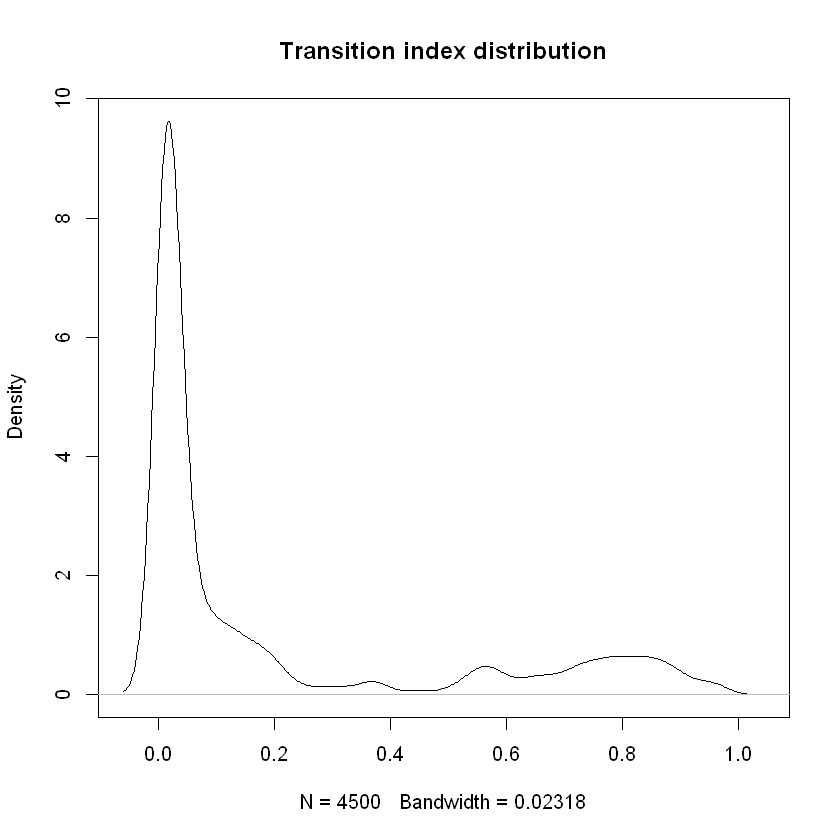

In [ ]:
plot(density(data$transition_index),main="Transition index distribution")
dev.off()

In [ ]:
# Separating cells into transiton cells and stable cells using GMM (Gaussian
# Mixture Model)
install.packages('mclust')
library(mclust)
fit<-Mclust(data$transition_index,G=2)
transition_cells<-colnames(data)[fit$classification==2 & fit$z[,2]>0.8]

package 'mclust' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\yingj\AppData\Local\Temp\Rtmp8KXMua\downloaded_packages


Package 'mclust' version 6.1.1
Type 'citation("mclust")' for citing this R package in publications.



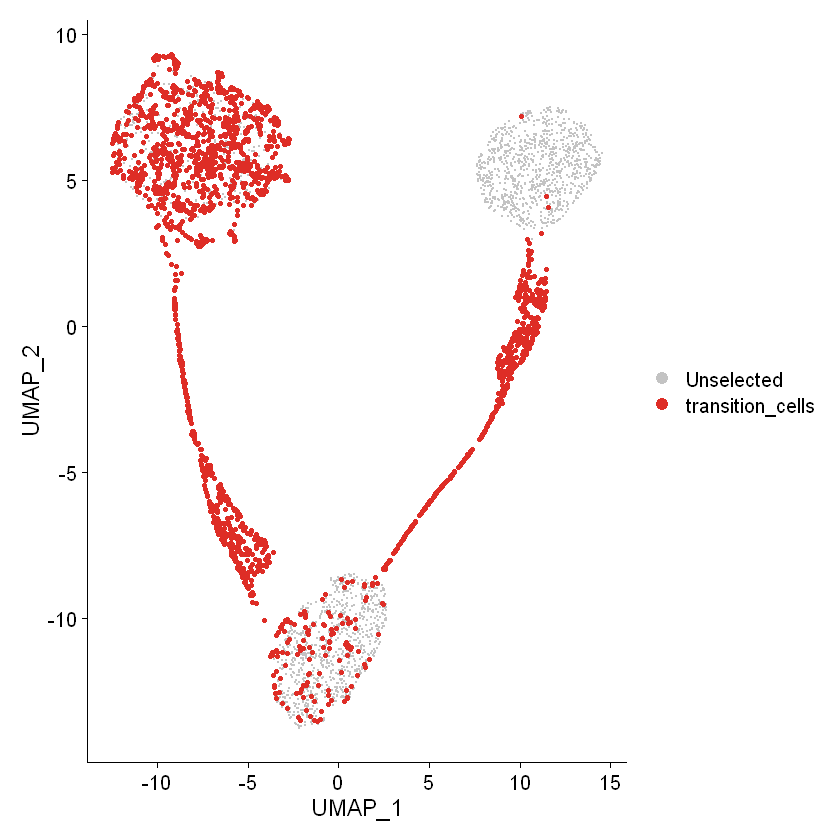

In [ ]:
# UMAP highlighted transition cells inferred by our method
DimPlot(data,cells.highlight = list('transition_cells'=transition_cells))